In [1]:
# Use this code if using Colab to run Selenium

# Make sure to go to Runtime -> Change runtime and set GPU as hardware accelerator

# !kill -9 -1 # Use this line to delete this VM and start a new one.
# The above line deletes all files and folders from the current VM and allocates a new one.

#Selenium is an open-source tool that automates web browsers.
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
#WebDriver is a browser automation framework that works with open source APIs.
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')

chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By

# Initialize a web driver (choose the appropriate driver for your browser)
driver = webdriver.Chrome()

# Initialize an empty list to store data from all pages
all_data = []

for page_number in range(1, 101):
    # Navigate to the forum page
    driver.get("https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p" + str(page_number))

    # Find all the message elements on the page
    message_elements = driver.find_elements(By.XPATH, '//div[@class="Message userContent"]')
    date_elements = driver.find_elements(By.XPATH, '//time[@title]')

    # Extract messages and dates
    messages = [message_element.text for message_element in message_elements]
    dates = [date_element.get_attribute("datetime") for date_element in date_elements]

    # Combine messages, dates, and page numbers and add to the list
    page_data = list(zip([page_number] * len(messages), dates, messages))
    all_data.extend(page_data)

# Create a DataFrame from all the data
df = pd.DataFrame(all_data, columns=['Page', 'Date', 'Message'])

# Convert the "Message" column to lowercase
df['Message'] = df['Message'].str.lower()

# Print or save the DataFrame as needed
print(df)

# Close the web browser
driver.quit()

      Page                       Date  \
0        1  2002-03-23T19:04:32+00:00   
1        1  2002-03-25T05:54:02+00:00   
2        1  2002-03-25T07:06:29+00:00   
3        1  2002-03-25T17:02:27+00:00   
4        1  2002-03-25T23:04:37+00:00   
...    ...                        ...   
4996   100  2006-01-24T04:51:58+00:00   
4997   100  2006-01-24T06:29:47+00:00   
4998   100  2006-01-25T02:39:15+00:00   
4999   100  2006-01-25T02:42:11+00:00   
5000   100  2006-01-25T05:10:58+00:00   

                                                Message  
0     entry level performance luxury sedans are a ho...  
1     i personally think that with a few tweaks the ...  
2     i am debating a new purchase and these two are...  
3     great handling, rwd, excellent engine and the ...  
4     and no manual tranny. that may not matter to y...  
...                                                 ...  
4996  i agree with blueguydotcom. the is350 is one f...  
4997  don't have any interest in aftermarke

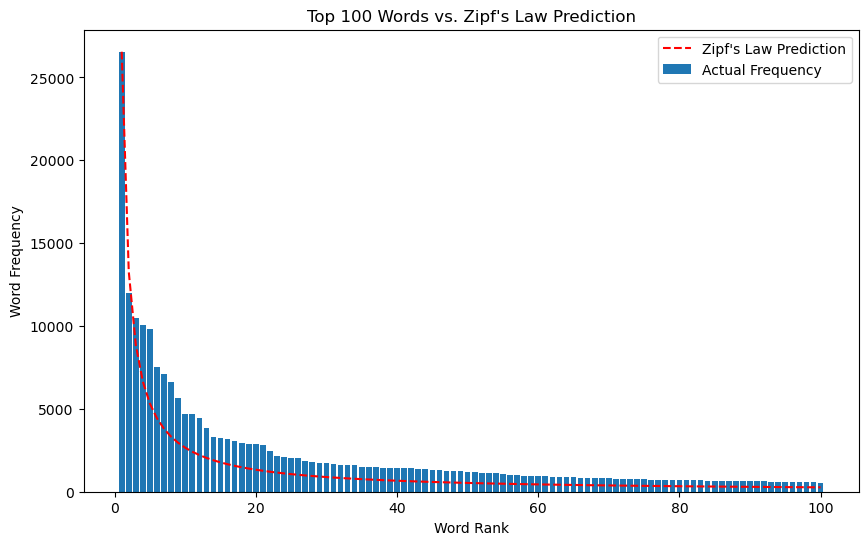

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Concatenate all messages into a single text corpus
corpus = " ".join(df['Message'])

# Tokenize the text into words (simple split by space)
words = corpus.split()

# Calculate word frequencies
word_freq = Counter(words)

# Get the 100 most common words
top_words = word_freq.most_common(100)

# Calculate the rank of each word
ranks = list(range(1, len(top_words) + 1))

# Calculate the theoretical prediction of Zipf's law
max_frequency = top_words[0][1]
zipf_prediction = [max_frequency / rank for rank in ranks]


# Plot the most common 100 words against the theoretical prediction
plt.figure(figsize=(10, 6))
plt.bar(ranks, [word[1] for word in top_words], label='Actual Frequency')
plt.plot(ranks, zipf_prediction, color='red', linestyle='--', label='Zipf\'s Law Prediction')
plt.xlabel('Word Rank')
plt.ylabel('Word Frequency')
plt.title('Top 100 Words vs. Zipf\'s Law Prediction')
plt.legend()
plt.show()

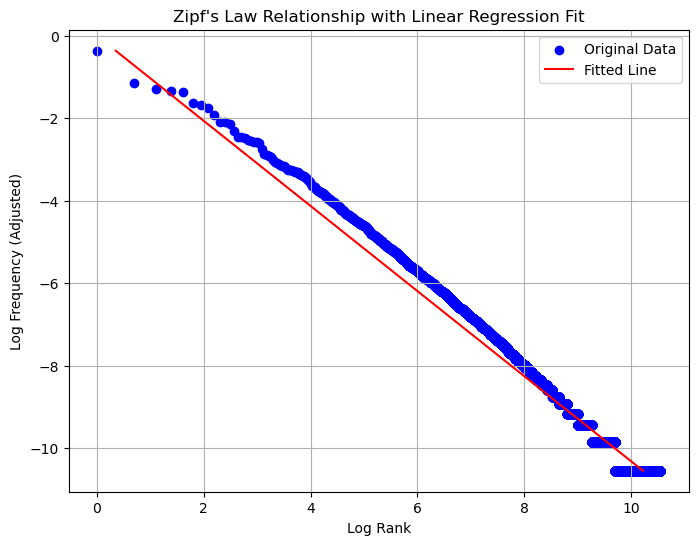

In [4]:
import numpy as np
zipfs_testing = pd.DataFrame({'ranks': list(range(1, len(word_freq.most_common()) + 1)),'frequency':[word[1] for word in word_freq.most_common()]})
zipfs_testing['log_rank'] = np.log(zipfs_testing['ranks'])
zipfs_testing['log_frequency_adjusted'] = np.log(zipfs_testing['frequency'] / (zipfs_testing['ranks'].iloc[-1] * zipfs_testing['frequency'].iloc[-1]))

X=zipfs_testing[['log_frequency_adjusted']]
Y=zipfs_testing[['log_rank']]

from sklearn.linear_model import LinearRegression

# Create a LinearRegression model
model = LinearRegression(fit_intercept=False)

# Fit the model with 'log_frequency_adjusted' as the independent variable and 'log_rank' as the dependent variable
model.fit(X, Y)

# Get the coefficients and intercept of the model
coef = model.coef_[0]
intercept = model.intercept_

# Create a scatter plot of the original data points
plt.figure(figsize=(8, 6))
plt.scatter(Y, X, marker='o', color='blue', label='Original Data')

# Plot the fitted regression line
plt.plot( model.predict(X),X, color='red', label='Fitted Line')

plt.xlabel('Log Rank')
plt.ylabel('Log Frequency (Adjusted)')
plt.title('Zipf\'s Law Relationship with Linear Regression Fit')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
import numpy as np
from scipy import stats

# Define your hypothesized value
hypothesized_value = -1

# Calculate the standard error of the coefficient estimate
standard_error_of_residuals = (((Y - model.predict(X))**2).mean()**0.5).item()
sum_of_squared_deviation_of_X_from_mean = np.sum((X - X.mean())**2).item()
standard_error = standard_error_of_residuals / np.sqrt(sum_of_squared_deviation_of_X_from_mean)

# Calculate the z-statistic (assuming a normal distribution)
z_statistic = (coef[0] - hypothesized_value) / standard_error

# Calculate the p-value (two-tailed)
p_value = 2 * (1 - stats.norm.cdf(abs(z_statistic)))

# Print z-statistic and p-values
print("z-Statistic:", z_statistic)
print("P-Values:", p_value)

print(f"\nWe must reject the null hypothesis that the true coefficient (theta value) is -1, however, for all effects and purposes, the coefficient value of {coef.item()} is close enough to -1 that we can say that zipf's law is valid in this case (assuming a normal distribution)")

z-Statistic: 30.473799349231225
P-Values: 0.0

We must reject the null hypothesis that the true coefficient (theta value) is -1, however, for all effects and purposes, the coefficient value of -0.9689328954069998 is close enough to -1 that we can say that zipf's law is valid in this case (assuming a normal distribution)


In [6]:
model_brand=pd.read_csv("car_models_and_brands.csv")
model_brand['Model'] = model_brand['Model'].str.lower()
model_brand['Brand'] = model_brand['Brand'].str.lower()

In [7]:
import pandas as pd
import nltk
from nltk.corpus import stopwords

df['Tokens'] = df['Message'].apply(nltk.word_tokenize)

stop_words = set(stopwords.words('english'))
df['Tokens'] = df['Tokens'].apply(lambda tokens: [word.lower() for word in tokens if word.lower() not in stop_words])

def replace_models_with_brands(x):
    i = 0
    replaced_tokens = []

    while i < len(x):
        brand_match = model_brand[model_brand['Model'] == x[i]]
        if not brand_match.empty:
            replaced_tokens.append(brand_match.iloc[0]['Brand'])
        else:
            replaced_tokens.append(x[i]) 
        i += 1
    return replaced_tokens
    
df['Tokens'] = df['Tokens'].apply(replace_models_with_brands)

In [8]:
brands_to_exclude = ['car', 'problem', 'seat','sedan']
filtered_brand_list = [brand for brand in model_brand["Brand"].unique() if brand not in brands_to_exclude]

In [9]:
from collections import defaultdict

# Create a defaultdict to count messages for each brand
brand_message_count = defaultdict(int)

# Iterate through the 'Tokens' column and count messages for each brand
for tokens in df['Tokens']:
    # Use a set to keep track of unique brands in each message
    unique_brands_in_message = set()
    
    for token in tokens:
        if token in filtered_brand_list:
            unique_brands_in_message.add(token)
    
    # Increment the message count for each unique brand in the message
    for brand in unique_brands_in_message:
        brand_message_count[brand] += 1

# Convert the defaultdict to a DataFrame for easy analysis
brand_message_count_df = pd.DataFrame({'Brand': list(brand_message_count.keys()), 'Message_Count': list(brand_message_count.values())})

# Sort the DataFrame by message count in descending order
brand_message_count_df = brand_message_count_df.sort_values(by='Message_Count', ascending=False)

# Print the top 10 brands by message count
top_10_brands = brand_message_count_df.head(10).reset_index(drop=True)
top_10_brands

,Brand,Message_Count
0,bmw,1406
1,acura,568
2,audi,425
3,honda,425
4,infiniti,398
5,toyota,311
6,nissan,304
7,subaru,210
8,volkswagen,148
9,ford,140


In [10]:
from itertools import combinations
all_combinations = list(combinations(top_10_brands["Brand"], 2))

df_combinations = pd.DataFrame(all_combinations, columns=["Brand1", "Brand2"])

print(df_combinations)

        Brand1      Brand2
0          bmw       acura
1          bmw        audi
2          bmw       honda
3          bmw    infiniti
4          bmw      toyota
5          bmw      nissan
6          bmw      subaru
7          bmw  volkswagen
8          bmw        ford
9        acura        audi
10       acura       honda
11       acura    infiniti
12       acura      toyota
13       acura      nissan
14       acura      subaru
15       acura  volkswagen
16       acura        ford
17        audi       honda
18        audi    infiniti
19        audi      toyota
20        audi      nissan
21        audi      subaru
22        audi  volkswagen
23        audi        ford
24       honda    infiniti
25       honda      toyota
26       honda      nissan
27       honda      subaru
28       honda  volkswagen
29       honda        ford
30    infiniti      toyota
31    infiniti      nissan
32    infiniti      subaru
33    infiniti  volkswagen
34    infiniti        ford
35      toyota      nissan
3

In [11]:
# Initialize an empty DataFrame to store results
result_columns = ['Brand1', 'Brand2', 'Brand1_Count', 'Brand2_Count', 'Brand1_Brand2_Cooccurrence_Count', 'Total_Messages']
result_df = pd.DataFrame(columns=result_columns)

# Calculate the total number of messages
total_messages = len(df['Tokens'])

# Loop through all combinations of brands
for brand_pair in df_combinations.itertuples(index=False):
    brand1, brand2 = brand_pair

    # Initialize Counters and Position Tracker
    count_brand1 = 0
    count_brand2 = 0
    count_cooccurrence = 0

    # Loop over messages
    for tokens in df['Tokens']:
        # Check total messages with Brand1
        if brand1 in tokens:
            count_brand1 += 1

        # Check total messages with Brand2
        if brand2 in tokens:
            count_brand2 += 1

        # Check for Co-occurrence within the same message (not more than 5 tokens apart)
        if brand1 in tokens and brand2 in tokens:
            indices_brand1 = [i for i, token in enumerate(tokens) if token == brand1]
            indices_brand2 = [i for i, token in enumerate(tokens) if token == brand2]

            for index1 in indices_brand1:
                for index2 in indices_brand2:
                    if abs(index1 - index2) <= 5:
                        count_cooccurrence += 1
                        break  # Break once co-occurrence is found in this message

    # Append results to the DataFrame
    result_df = pd.concat([result_df, pd.DataFrame({'Brand1': [brand1], 'Brand2': [brand2],
                                  'Brand1_Count': [count_brand1],
                                  'Brand2_Count': [count_brand2],
                                  'Brand1_Brand2_Cooccurrence_Count': [count_cooccurrence],
                                  'Total_Messages': [total_messages]})],
                          ignore_index=True)

result_df


,Brand1,Brand2,Brand1_Count,Brand2_Count,Brand1_Brand2_Cooccurrence_Count,Total_Messages
0,bmw,acura,1406,568,88,5001
1,bmw,audi,1406,425,110,5001
2,bmw,honda,1406,425,27,5001
3,bmw,infiniti,1406,398,115,5001
4,bmw,toyota,1406,311,25,5001
5,bmw,nissan,1406,304,16,5001
6,bmw,subaru,1406,210,14,5001
7,bmw,volkswagen,1406,148,12,5001
8,bmw,ford,1406,140,9,5001
9,acura,audi,568,425,49,5001


In [12]:
result_df

,Brand1,Brand2,Brand1_Count,Brand2_Count,Brand1_Brand2_Cooccurrence_Count,Total_Messages
0,bmw,acura,1406,568,88,5001
1,bmw,audi,1406,425,110,5001
2,bmw,honda,1406,425,27,5001
3,bmw,infiniti,1406,398,115,5001
4,bmw,toyota,1406,311,25,5001
5,bmw,nissan,1406,304,16,5001
6,bmw,subaru,1406,210,14,5001
7,bmw,volkswagen,1406,148,12,5001
8,bmw,ford,1406,140,9,5001
9,acura,audi,568,425,49,5001


C:\Users\naksh\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


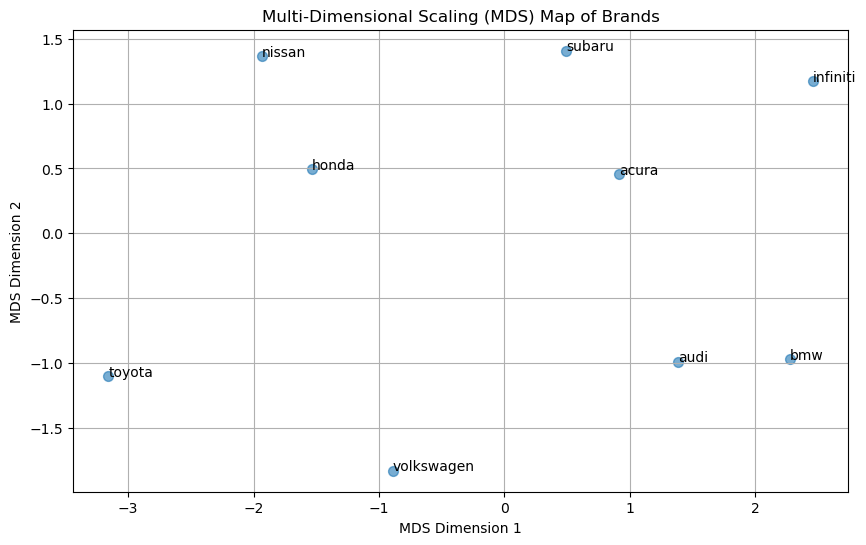

In [13]:
result_df["lift"]=(result_df["Brand1_Brand2_Cooccurrence_Count"]/result_df["Total_Messages"])/((result_df["Brand1_Count"]/result_df["Total_Messages"])*(result_df["Brand2_Count"]/result_df["Total_Messages"]))

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a DataFrame called 'result_df' with lift ratios
brands = result_df['Brand1'].unique()
num_brands = len(brands)

# Create an empty square dissimilarity matrix
dissimilarity_matrix = np.zeros((num_brands, num_brands))

# Calculate dissimilarity between all pairs of brands
for i in range(num_brands):
    for j in range(i+1, num_brands):
        brand1 = brands[i]
        brand2 = brands[j]
        
        # Calculate dissimilarity based on your lift ratios (modify this part)
        dissimilarity = 1 / result_df.loc[
            (result_df['Brand1'] == brand1) & (result_df['Brand2'] == brand2), 'lift'
        ].values[0]
        
        # Fill both symmetric positions in the matrix
        dissimilarity_matrix[i, j] = dissimilarity
        dissimilarity_matrix[j, i] = dissimilarity

# Initialize MDS with 2 components for a 2D map
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)

# Fit MDS and obtain 2D coordinates
mds_coordinates = mds.fit_transform(dissimilarity_matrix)

# Create a new DataFrame with brand names and MDS coordinates
mds_df = pd.DataFrame({'Brand': brands,
                        'X': mds_coordinates[:, 0],
                        'Y': mds_coordinates[:, 1]})

# Plot the MDS map
plt.figure(figsize=(10, 6))
plt.scatter(mds_df['X'], mds_df['Y'], s=50, alpha=0.6)
for i, brand in enumerate(mds_df['Brand']):
    plt.annotate(brand, (mds_df['X'][i], mds_df['Y'][i]), fontsize=10)
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('Multi-Dimensional Scaling (MDS) Map of Brands')
plt.grid(True)
plt.show()